# Multirotor co-design with FAST-OAD

FAST-OAD is a framework for performing rapid Overall Aircraft Design co-developped by ONERA and ISAE-SUPAERO. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/).

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [CeRAS reference case](http://ceras.ilr.rwth-aachen.de/trac/wiki/CeRAS/AircraftDesigns/CSR01). In `workdir/`, we store files generated or modified by FAST-OAD.

In [1]:
import os
import os.path as pth
import openmdao.api as om
from fastoad import api
import logging
from fastoad.utils.postprocessing import VariableViewer
import shutil
from models.register import register_openmdao_systems
from models.trajectory import plot_trajectory
register_openmdao_systems()
DATA_FOLDER_PATH = 'data'

WORK_FOLDER_PATH = 'workdir'

CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH,'multirotor.toml')
REF_INPUT_FILE = pth.join(DATA_FOLDER_PATH,'problem_inputs_ref.xml')
# For having log messages on screen
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# For using all screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


After defining a configuration file name, we can ask FAST-OAD to generate a default configuration file based on the default OAD model implemented in the framework:

In this configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-OAD to generate the inputs of the default model with the CeRAS parameters as default values:

In [2]:
api.generate_inputs(CONFIGURATION_FILE, REF_INPUT_FILE, overwrite=True)

INFO    : Problem inputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_inputs.xml


You can now checkout the generated [input file](./workdir/problem_inputs.xml). As shown previously in the user file architecture, the values in this file can be modified by the user and will be considered by FAST-OAD when executing a computational process.

A useful feature that FAST-OAD provides is to list the outputs of the model defined in the configuration file:

In [3]:
api.list_variables(CONFIGURATION_FILE)

,I/O,Name,Description
0,IN,data:battery:capacity:discharge_limit,
1,IN,data:battery:cell:voltage,
2,IN,data:battery:energy:ref,
3,IN,data:battery:mass:k,
4,IN,data:battery:mass:ref,
5,IN,data:battery:voltage:k,
6,IN,data:esc:efficiency,
7,IN,data:esc:mass:ref,
8,IN,data:esc:power:ref,
9,IN,data:frame:arm:density,


Another useful feature is to list the modules of the model defined in the configuration file:

In [4]:
api.list_systems(CONFIGURATION_FILE)

== AVAILABLE SYSTEM IDENTIFIERS ====================================================================
----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.highspeed.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_high_speed.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic polar of the aircraft in cruise conditions.

    Drag contributions of each part of the aircraft are computed though analytical
    models.

----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.landing.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_landing.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic characteristics at landing.

Another useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [5]:
N2_FILE = pth.join(WORK_FOLDER_PATH, 'n2.html')
api.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width='100%', height='500px')

INFO    : N2 diagram written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\n2.html


Alternatively, you can create a [WhatsOpt](https://github.com/OneraHub/WhatsOpt-Doc#whatsopt-documentation) account to generate the XDSM of the problem. If your account is created, you may uncomment next lines and run them (this should take ~ 1 min):

In [6]:
# XDSM_FILE = pth.join(WORK_FOLDER_PATH, 'xdsm.html')
# api.write_xdsm(CONFIGURATION_FILE, XDSM_FILE, overwrite=True)
# from IPython.display import IFrame
# IFrame(src=XDSM_FILE, width='100%', height='500px')

## 2. Running your first MDA

### CeRAS
Here we run an MDA, that is solving the multidisciplinary couplings using the different nested solvers in the model, without running the optimization problem even if it is defined in the configuration file.

In [7]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_inputs.xml')
api.variable_viewer(INPUT_FILE)

In [8]:
eval_problem = api.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Computation finished after 0.07 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01853309999999908 seconds.


Let's save these results. We will use them in the next workbook, that shows some post-processing utilities.

In [9]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

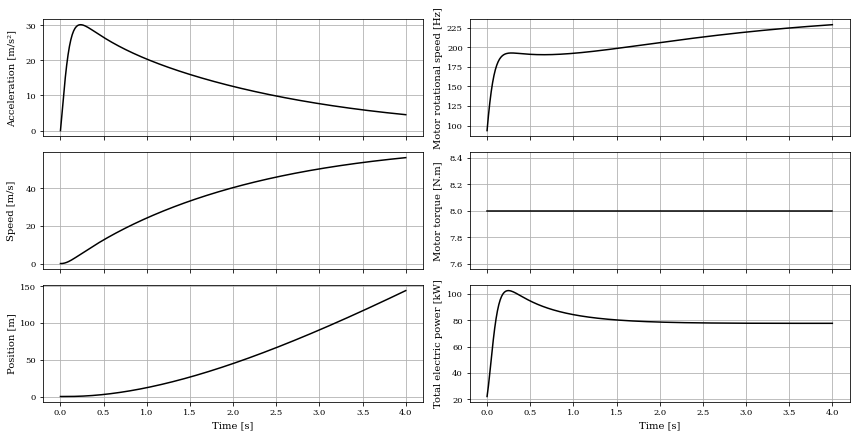

In [10]:
plot_trajectory(eval_problem.model.trajectory.trajectory.res)

The `variable-viewer` provides a way to inspect the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [11]:
api.variable_viewer(OUTPUT_FILE)

## 3. Running your first MDO

## CeRAS 2750 nm optimization

As seen earlier, the current aircraft configuration is estimated as unstable. We will fix this using a simple optimization problem that will move wing position so the static margin is at least +5%, while keeping the fuel consumption as low as possible. 

The default configuration file defines this optimization problem that aims at:
- minimizing the fuel consumption for the mission (objective),
- with respect to the wing position (design variables),
- subject to a static margin (constraints).

*(This run should take a few dozen seconds)*

To visualize and edit the optimization problem definition (present in the configuration file .toml) you can use the `optimization_viewer` tool. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated. Modifiying the `Initial Value` will modify the input file defined in the configuration file .toml whereas `Value` corresponds to the value found in the output file defined in the configuration file (here it is the 800 nm MDA run).

In [12]:
api.optimization_viewer(CONFIGURATION_FILE)

In [2]:
optim_problem = api.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018644800000000572 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0195375999999996 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.020208900000000085 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01898130000000009 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018733500000001513 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018600100000000452 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018158299999999628 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018573199999998735 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01839

Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.01866840000000103 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.01939959999999985 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.0184268000000003 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.01920390000000083 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.019816099999999892 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.018493500000001717 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.01969139999999925 seconds.
Simulation interval    : 0.0 - 5.5064665734933245 seconds.
Elapsed simulation time: 0.018096700000000965 seconds.
Simulation interval    : 0.0 - 5.5064665734933245 seconds.
Elapsed simulation time: 0.019716400000000

Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.02434380000000047 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.01826329999999743 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.01886429999999706 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.019445699999998567 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.01898519999999948 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.019278899999999766 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.018391099999998772 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.018770899999999813 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.018515900000000

Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.019283400000002615 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.019440500000001748 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.018585500000000366 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.01914019999999894 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.018476400000000837 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.018488200000000177 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.018531100000000578 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.018447399999999448 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.018780400000000697 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.02323849999999794 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.018471699999999203 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.019211999999999563 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.01863039999999927 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.02011089999999882 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.01841259999999778 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.018398999999998722 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.019611999999998

Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.01913419999999988 seconds.
Simulation interval    : 0.0 - 2.417804757351899 seconds.
Elapsed simulation time: 0.020374900000000196 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.020014400000000876 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.019072899999997617 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.018689599999998308 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.024213100000000765 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.018508500000002925 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.018745500000001414 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.0187

Simulation interval    : 0.0 - 2.564133182712374 seconds.
Elapsed simulation time: 0.018850799999999168 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.021260599999997964 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.018843600000000293 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.020035000000000025 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.018302200000000823 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.01847529999999864 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.019756500000003285 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.018934999999999036 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.019073399999

Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.019046400000000574 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.01889320000000083 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.0187361000000017 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.018750700000001785 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.01827959999999962 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.02006629999999987 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.018359400000001358 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.01912980000000175 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.01848260

Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.01883680000000254 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.01880519999999919 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.018868900000001076 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.020944100000001242 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.021174300000001978 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.018916700000001896 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.01860500000000087 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.019489999999997565 seconds.
Simulation interval    : 0.0 - 2.558619016560426 seconds.
Elapsed simulation time: 0.01823729999999

Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.018715300000000212 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.01865619999999879 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.019964099999999263 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.018907200000001012 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.018725299999999834 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.018695600000000923 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.01806969999999808 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.019173699999999627 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.0204

Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.018406300000002318 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.01880700000000246 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.01855600000000024 seconds.
Simulation interval    : 0.0 - 2.6638249215775334 seconds.
Elapsed simulation time: 0.018576199999998266 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.019909800000000644 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.020161899999997956 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.018859299999999024 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.018335000000000434 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.0184

Simulation interval    : 0.0 - 2.748714975379822 seconds.
Elapsed simulation time: 0.019561400000000617 seconds.
Simulation interval    : 0.0 - 2.748714975379822 seconds.
Elapsed simulation time: 0.018195200000000966 seconds.
Simulation interval    : 0.0 - 2.8813460504341872 seconds.
Elapsed simulation time: 0.01846570000000014 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.019584000000001822 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.021709899999997617 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.01997019999999594 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.01907190000000014 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.019427000000000305 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.0194571999999

Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.018922899999999743 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.018566700000000935 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.0189347999999967 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.018545199999998374 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.019144900000000575 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.01857859999999789 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.018327100000000485 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.018565599999995186 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.01850

Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.018788299999997093 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.01882930000000016 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.018880199999998126 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.018838099999996416 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.018999000000000876 seconds.
Simulation interval    : 0.0 - 2.781056017557861 seconds.
Elapsed simulation time: 0.01890250000000293 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.01997189999999449 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.018897899999998913 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.018549

Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.020091499999999485 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.02134720000000101 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.03857969999999966 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.019228599999998153 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.019609800000004896 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.023367200000002697 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.018837299999994173 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.01870330000000564 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.02001860000000

Simulation interval    : 0.0 - 2.7805791559143986 seconds.
Elapsed simulation time: 0.019265400000001875 seconds.
Simulation interval    : 0.0 - 2.781002331718662 seconds.
Elapsed simulation time: 0.019231400000002452 seconds.
Simulation interval    : 0.0 - 2.781059801178419 seconds.
Elapsed simulation time: 0.018693300000002466 seconds.
Simulation interval    : 0.0 - 2.7810677172569402 seconds.
Elapsed simulation time: 0.019293699999998637 seconds.
Simulation interval    : 0.0 - 2.7810688091145153 seconds.
Elapsed simulation time: 0.01909260000000046 seconds.
Simulation interval    : 0.0 - 2.781068954807252 seconds.
Elapsed simulation time: 0.019085199999999247 seconds.
Simulation interval    : 0.0 - 2.781068954807252 seconds.
Elapsed simulation time: 0.02191169999999687 seconds.
Simulation interval    : 0.0 - 2.781068954807252 seconds.
Elapsed simulation time: 0.01924759999999992 seconds.
Simulation interval    : 0.0 - 2.781068954807252 seconds.
Elapsed simulation time: 0.02100910000

Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.019216800000002365 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.018903999999999144 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.02112600000000242 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.019169699999999068 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.018834199999993473 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.019232999999999834 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.018078400000000272 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.020622599999995828 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.01845639999999804 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.020707000000001585 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.018298099999995543 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.018365899999999158 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.01819430000000466 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.01918810000000093 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.01880060000000583 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.01834689999999739 seconds.
Simulation interval    : 0.0 - 3.0632618649947396 seconds.
Elapsed simulation time: 0.018497599999996

Simulation interval    : 0.0 - 2.8833883881840356 seconds.
Elapsed simulation time: 0.020548999999995488 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.020132099999997877 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.018754700000002344 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.018537799999997162 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.018791000000000224 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.01858829999999756 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.018675399999999343 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.02018640000000005 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.0181

Simulation interval    : 0.0 - 2.7612337044030784 seconds.
Elapsed simulation time: 0.01959099999999836 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.01891010000000648 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.01902640000000133 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.01846700000000112 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.020481300000000147 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.01882770000000278 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.019122199999998202 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.018426600000005067 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.0201893

Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.02110870000000631 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.018464900000005002 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.018549999999997624 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.01835799999999921 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.020811600000001818 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.020248299999998665 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.01917060000000248 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.019242499999997165 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.01818409999999

Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.01909279999999569 seconds.
Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.018383599999999944 seconds.
Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.019097899999998447 seconds.
Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.020514800000000832 seconds.
Simulation interval    : 0.0 - 2.758832633445728 seconds.
Elapsed simulation time: 0.019766700000005244 seconds.
Simulation interval    : 0.0 - 2.758832633445728 seconds.
Elapsed simulation time: 0.019044999999998424 seconds.
Simulation interval    : 0.0 - 2.758832633445728 seconds.
Elapsed simulation time: 0.018361499999997477 seconds.
Simulation interval    : 0.0 - 2.758832633445728 seconds.
Elapsed simulation time: 0.018296100000000592 seconds.
Simulation interval    : 0.0 - 2.758832633445728 seconds.
Elapsed simulation time: 0.01920309

Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.028357100000000912 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.019776999999997713 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.018549800000002392 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.019230999999997778 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.01858989999999494 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.018626399999995158 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.019547299999999268 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.018582600000002003 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.019

Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.019674100000003136 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.018970500000001778 seconds.
Simulation interval    : 0.0 - 2.781462212256408 seconds.
Elapsed simulation time: 0.018545800000005386 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.02001210000000242 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.01842770000000371 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.01944059999999581 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.018293400000004567 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.01825459999999879 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.018135400000005

Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.01997519999999753 seconds.
Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.018416200000004324 seconds.
Simulation interval    : 0.0 - 2.9041402722794607 seconds.
Elapsed simulation time: 0.018886799999997095 seconds.
Simulation interval    : 0.0 - 2.793930949531289 seconds.
Elapsed simulation time: 0.019102600000003633 seconds.
Simulation interval    : 0.0 - 2.7829100172564716 seconds.
Elapsed simulation time: 0.018625900000003526 seconds.
Simulation interval    : 0.0 - 2.78180792402899 seconds.
Elapsed simulation time: 0.019817299999999705 seconds.
Simulation interval    : 0.0 - 2.78180792402899 seconds.
Elapsed simulation time: 0.019203000000004522 seconds.
Simulation interval    : 0.0 - 2.78180792402899 seconds.
Elapsed simulation time: 0.01826669999999808 seconds.
Simulation interval    : 0.0 - 2.78180792402899 seconds.
Elapsed simulation time: 0.0185274999999

Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.0184014000000019 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.018559400000000892 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.03360829999999737 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.019306400000004942 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.019460199999997485 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.018868799999999908 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.020145199999994645 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.018977799999994716 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.01976

Simulation interval    : 0.0 - 2.8761506936282584 seconds.
Elapsed simulation time: 0.018849199999998234 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.018822499999998854 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.02013610000000199 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.018330100000000016 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.01918600000000481 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.01858169999999859 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.018260200000000282 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.018383999999997513 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.0186494000000

Simulation interval    : 0.0 - 2.894012286569646 seconds.
Elapsed simulation time: 0.018554599999994537 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.019266999999999257 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.018461099999996122 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.018507999999997082 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.01827270000000425 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.018260900000001357 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.018855000000002065 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.018365099999996914 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.0185

Simulation interval    : 0.0 - 2.900553772305852 seconds.
Elapsed simulation time: 0.018941199999986225 seconds.
Simulation interval    : 0.0 - 2.9005547723058527 seconds.
Elapsed simulation time: 0.031192000000004327 seconds.
Simulation interval    : 0.0 - 2.900553772305852 seconds.
Elapsed simulation time: 0.02087099999999964 seconds.
Simulation interval    : 0.0 - 2.900553772305852 seconds.
Elapsed simulation time: 0.024103600000003667 seconds.
Simulation interval    : 0.0 - 2.900553772305852 seconds.
Elapsed simulation time: 0.018576799999991067 seconds.
Simulation interval    : 0.0 - 2.900553772305852 seconds.
Elapsed simulation time: 0.019129599999999414 seconds.
Simulation interval    : 0.0 - 2.900553772305852 seconds.
Elapsed simulation time: 0.018252300000000332 seconds.
Simulation interval    : 0.0 - 2.900553772305852 seconds.
Elapsed simulation time: 0.018606399999995915 seconds.
Simulation interval    : 0.0 - 2.900553772305852 seconds.
Elapsed simulation time: 0.01950479999

Simulation interval    : 0.0 - 2.8895407383497624 seconds.
Elapsed simulation time: 0.018885299999993777 seconds.
Simulation interval    : 0.0 - 2.8895407383497624 seconds.
Elapsed simulation time: 0.020178999999998837 seconds.
Simulation interval    : 0.0 - 2.8895407383497624 seconds.
Elapsed simulation time: 0.018431300000003148 seconds.
Simulation interval    : 0.0 - 2.8895407383497624 seconds.
Elapsed simulation time: 0.018802499999992506 seconds.
Simulation interval    : 0.0 - 2.8895407383497624 seconds.
Elapsed simulation time: 0.01851529999999002 seconds.
Simulation interval    : 0.0 - 2.8895407383497624 seconds.
Elapsed simulation time: 0.017582400000009102 seconds.
Simulation interval    : 0.0 - 2.8895407383497624 seconds.
Elapsed simulation time: 0.018576699999997004 seconds.
Simulation interval    : 0.0 - 2.8895407383497624 seconds.
Elapsed simulation time: 0.018425799999988612 seconds.
Simulation interval    : 0.0 - 2.889541738349762 seconds.
Elapsed simulation time: 0.0205

Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.018742099999997208 seconds.
Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.01834719999999379 seconds.
Simulation interval    : 0.0 - 2.8922759361141477 seconds.
Elapsed simulation time: 0.030829500000010057 seconds.
Simulation interval    : 0.0 - 2.8922759361141477 seconds.
Elapsed simulation time: 0.01920830000000251 seconds.
Simulation interval    : 0.0 - 2.8922759361141477 seconds.
Elapsed simulation time: 0.018882199999993077 seconds.
Simulation interval    : 0.0 - 2.8922759361141477 seconds.
Elapsed simulation time: 0.018717499999993947 seconds.
Simulation interval    : 0.0 - 2.8922759361141477 seconds.
Elapsed simulation time: 0.01834379999999669 seconds.
Simulation interval    : 0.0 - 2.8922759361141477 seconds.
Elapsed simulation time: 0.019065000000011878 seconds.
Simulation interval    : 0.0 - 2.8922759361141477 seconds.
Elapsed simulation time: 0.0195049

Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.01939590000000635 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.019136399999993614 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.0201945999999964 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.01894699999999716 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.01860169999999073 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.018625600000007125 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.018669900000006123 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.018564800000007153 seconds.
Simulation interval    : 0.0 - 2.8923144851777045 seconds.
Elapsed simulation time: 0.018887800000001

INFO    : Computation finished after 57.84 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.162813680913776
            Iterations: 83
            Function evaluations: 238
            Gradient evaluations: 83
Optimization Complete
-----------------------------------


Let's save these results:

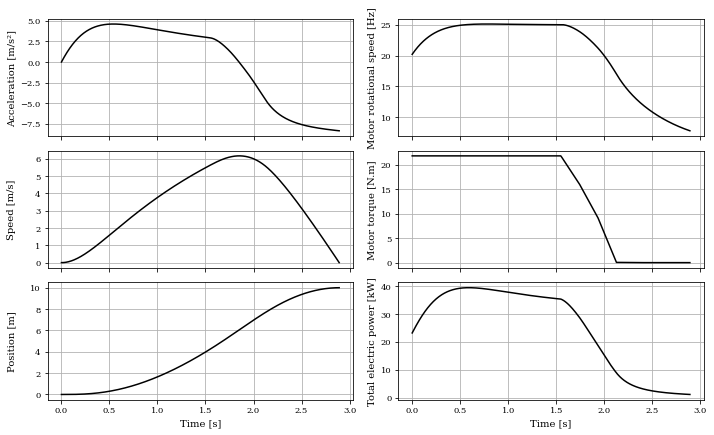

In [3]:
plot_trajectory(optim_problem.model.trajectory.trajectory.res)

In [4]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

The `optimizer_viewer` offers a convenient summary of the optimization result:

In [5]:
api.optimization_viewer(CONFIGURATION_FILE)

You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [6]:
api.variable_viewer(OUTPUT_FILE)

In [18]:
# Checking the complete model
import openmdao.api as om
from models.multirotor import Multirotor
prob = om.Problem()
prob.model = Multirotor()

prob.setup(check=True)

RuntimeError: <model> <class Multirotor>: Output name 'data:system:MTOW' refers to multiple outputs: ['mtow.data:system:MTOW', 'system_constraints.mtow.data:system:MTOW'].